In [270]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [271]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"

In [251]:
#not used currently
def get_max_score(matrix):
    """
    input: result = out['data'].values matrix (e.g. for distilgpt2 a matrix of dimensions 7x2)
    output: maximum score and associated error for this matrix.
    """
    max_score, error = 0,0
    for i in range(len(matrix)):
        if matrix[i][0] > max_score:
            max_score = matrix[i][0]
            error = matrix[i][1]
    return max_score, error

In [254]:
#not used currently
def get_best_score_dict(model_identifier):
    """
    input: model_identifier
    output: dictionary containing the maximum score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    score_dict = {}
    for filename in os.listdir(working_dir):
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
            print(condition)
            if not condition in score_dict:
                score_dict[condition] = {}
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            result = out['data'].values
            #print(result, '\n\n')
            max_score, error = get_max_score(result)
            score_dict[condition]['score'] = max_score
            score_dict[condition]['error'] = error
    return score_dict

In [272]:
def get_last_scores_df(model_identifier):
    """
    input: model_identifier
    output: dictionary containing the last score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    conditions = []
    last_scores = []
    errors = []
    for filename in os.listdir(working_dir):
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
            if "-" in condition:
                condition = condition.split("-")[1]
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            result = out['data'].values
            #print(result, '\n\n')
            last_score, error = last_score, error = result[-1][0], result[-1][1]
            conditions.append(condition)
            last_scores.append(last_score)
            errors.append(error)
    import pandas as pd
    index = conditions
    df = pd.DataFrame({'score': last_scores,
    'error': errors, 'condition':conditions})
    df['condition'] = pd.Categorical(df['condition'], categories=['original', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'lowpmi', 'backward', 'random'])
    scores_df = df.sort_values(by='condition')
    return scores_df

In [282]:
scores_df = get_last_scores_df('distilgpt2')

### Quick sanity check

In [283]:
print(conditions)
print('\n')
print(last_scores)
print('\n')
print(errors)

['backward', 'lowpmi', 'original', 'random', 'scrambled1', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7']


[0.6242322875672722, 0.5256760427989734, 0.4454864441157622, 0.3564891344485661, 0.43310878403260544, 0.43310878403260544, 0.4811030135041988, 0.5098417301536319, 0.4229061986841613]


[0.11694741833283831, 0.09444549033749307, 0.14169167045674563, 0.025444802149656724, 0.1525445876197933, 0.1525445876197933, 0.09208122636707647, 0.20404803568458746, 0.156048807773573]


In [284]:
scores_df

,score,error,condition
2,0.445486,0.141692,original
4,0.433109,0.152545,scrambled1
5,0.433109,0.152545,scrambled1
6,0.481103,0.092081,scrambled3
7,0.509842,0.204048,scrambled5
8,0.422906,0.156049,scrambled7
1,0.525676,0.094445,lowpmi
0,0.624232,0.116947,backward
3,0.356489,0.025445,random


In [454]:
def bar_plot(model_identifier,get_last_scores_df):
    colors = sns.color_palette("rocket")
    x_pos = np.arange(len(get_last_scores_df))
    scores = get_last_scores_df['score']
    errors = get_last_scores_df['error']
    conditions = get_last_scores_df['condition']
    fig, ax = plt.subplots()
    ax.bar(x_pos, scores,
       yerr=errors,
       align='center',
       alpha=0.8, #color intensity
       ecolor='black',
       capsize=5, #error bar width
       color=colors[1]) #if you put just color=colors, you get the bar plots in different rocket palette colors
    ax.set_ylabel('ceiled score',fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(conditions, rotation=60)
    ax.set_title('{}'.format(model_identifier),fontsize=18)
    ax.yaxis.grid(True)

In [455]:
def main_plot(model_identifier):
    scores_df = get_last_scores_df(model_identifier)
    bar_plot(model_identifier,scores_df)

# Ready to plot!

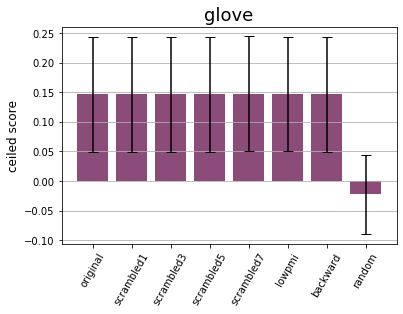

In [456]:
main_plot('glove')

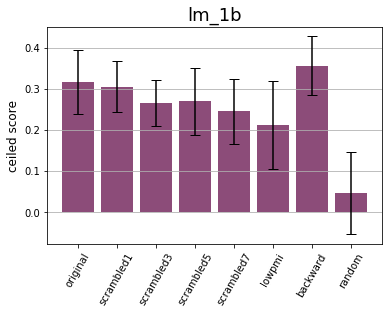

In [360]:
main_plot('lm_1b')

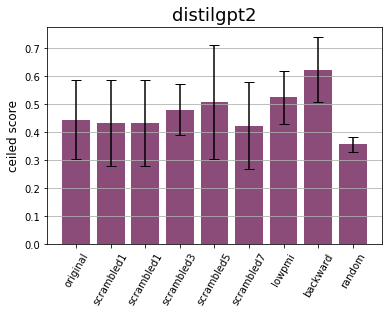

In [361]:
main_plot('distilgpt2')

# Loop to create subplots

In [484]:
import math
from matplotlib.gridspec import GridSpec

def get_subplots_loop(model_list):
    nsubplots = len(model_list)
    nrows = math.ceil(nsubplots/2)
    colors = sns.color_palette("rocket")
    
    fig2 = plt.figure(constrained_layout=True, figsize=(15, 7))
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    counter = 0
    for i in range(nrows):
        for j in range(2):
            if counter + 1 > nsubplots:
                break
            else:
                scores_df = get_last_scores_df(model_list[counter])
                x_pos = np.arange(len(scores_df))
                scores = scores_df['score']
                errors = scores_df['error']
                conditions = scores_df['condition']

                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                f2_ax[-1].bar(x_pos, scores,
                       yerr=errors,
                       align='center',
                       alpha=0.8, #color intensity
                       ecolor='black',
                       capsize=5, #error bar width
                       color=colors[1]) #if you put just color=colors, you get the bar plots in different rocket palette colors
                f2_ax[-1].set_ylabel('ceiled score',fontsize=12)
                f2_ax[-1].set_xticks(x_pos)
                f2_ax[-1].set_xticklabels(conditions, rotation=60)
                f2_ax[-1].set_title('{}'.format(model_list[counter]),fontsize=18)
                f2_ax[-1].yaxis.grid(True)
                counter += 1

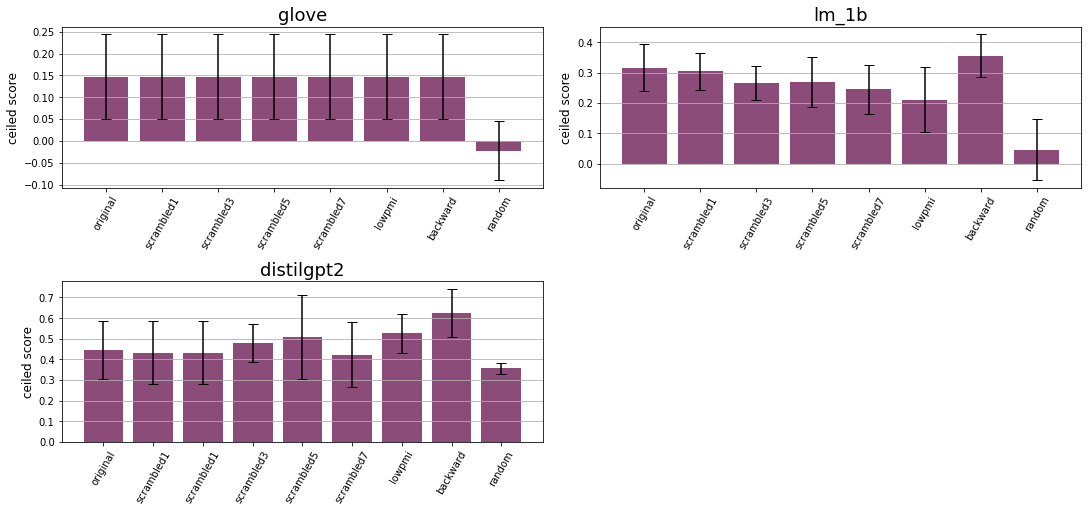

In [485]:
get_subplots_loop(['glove','lm_1b','distilgpt2'])